/home/tfaucett/miniconda3/envs/tf/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/tfaucett/miniconda3/envs/tf/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tfaucett/miniconda3/envs/tf/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/tfaucett/miniconda3/envs/tf/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tfaucett/miniconda3/envs/tf/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/tfaucett/miniconda3/

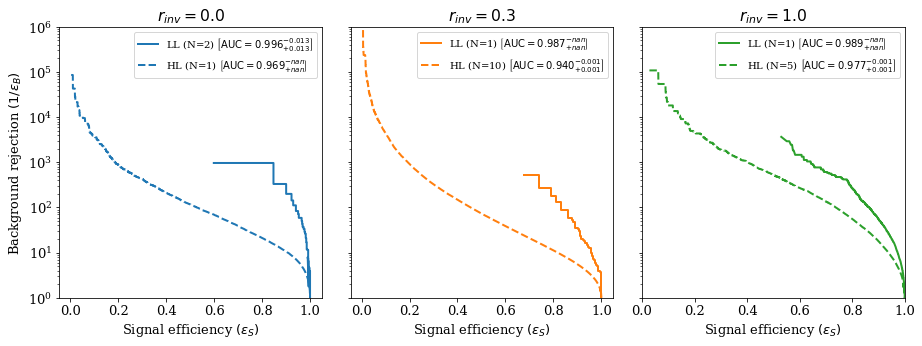

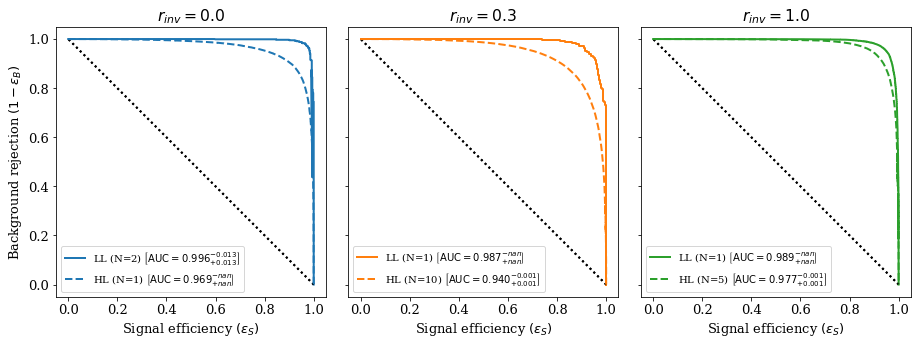

In [55]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import pathlib
import scipy.stats

path = pathlib.Path.cwd()
np.seterr(divide='ignore')

plt.rcParams["font.family"] = "serif"
matplotlib.rcParams.update({'font.size': 13})

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def average_curve(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1)

rinvs = ["0p0", "0p3", "1p0"]
data_types = ["LL", "HL"]
colors = ["tab:blue", "tab:orange", "tab:green"]

bkgRej_log = True

for bkgRej_log in (True, False):
    fig, axs = plt.subplots(1, 3, figsize=(13, 5), sharey=True)
    for rix, rinv in enumerate(rinvs):
        for data_type in data_types:
            auc_file = path.parent / f'{data_type}_training' / 'bootstrap_results' / rinv / 'aucs.csv'
            if auc_file.exists():
                aucs = pd.read_csv(auc_file).auc.values
                auc_avg, auc_min, auc_max = mean_confidence_interval(aucs)
                roc_path = path.parent / f'{data_type}_training' / 'bootstrap_results' / rinv / 'roc'
                xs, ys = [], []
                for ix, (roc_file, auc) in enumerate(zip(list(roc_path.glob('*')), aucs)):
                    roc_df = pd.read_csv(roc_file, index_col=0)
                    xs.append(roc_df.sig_eff.values)
                    ys.append(roc_df.bkg_eff.values)
                x = average_curve(xs)
                y = average_curve(ys)
                
                rinv_str = rinv.replace("p", ".")
                if data_type == "HL":
                    ls = "--"
                else:
                    ls = "-"
                label = '%s (N=%s) $\\left[\mathrm{AUC} = %0.3f_{+%0.3f}^{-%0.3f}\\right]$' %(data_type, len(aucs), auc_avg, np.abs(auc_min-auc_avg), np.abs(auc_max-auc_avg))
                axs[rix].set_title("$r_{inv} = %s$" %rinv_str)
                if bkgRej_log:
                    axs[rix].plot(x, 1. / y, lw=2, color=colors[rix], alpha=1, linestyle=ls, label=label)
#                     axs[rix].fill_between(x, 1. / y_min, 1. / y_max, lw=2, color=colors[rix], alpha=0.2)
                    axs[0].set_ylabel('Background rejection $(1 / \epsilon_B)$')
                    plt.yscale('log')
                    plt.xlim(left=0, right=1)
                    plt.ylim(bottom=1, top=1e6)
                    axs[rix].legend(loc='upper right', fontsize="10")
                    plt.savefig(path.parent / "figures" / "bootstrap_roc.png")
                    plt.savefig(path.parent / "figures" / "bootstrap_roc.pdf")
                else:
                    axs[rix].plot([1,0], [0,1], lw=2, color="k", linestyle="dotted")
                    axs[rix].plot(x, 1. - y, lw=2, color=colors[rix], alpha=1, linestyle=ls, label=label)
                    axs[0].set_ylabel('Background rejection $(1 - \epsilon_B)$')
                    axs[rix].legend(loc='lower left', fontsize="10")
                    axs[rix].set_aspect('equal')
                    plt.savefig(path.parent / "figures" / "log_bootstrap_roc.png")
                    plt.savefig(path.parent / "figures" / "log_bootstrap_roc.pdf")
                axs[rix].set_xlabel('Signal efficiency $(\epsilon_S)$')
    plt.subplots_adjust(wspace=0.1)
    plt.tight_layout()